### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1.[ Import libraries](#1)
  
2.[ Data cleaning](#2)
    
3.[ RFM](#3)
    
4.[ Exploratory Data Analysis](#4)
    
5.[ Feature Engineering](#5)
    
6.[ Segmenation](#6)

# 1. Import libraries <a class='anchor' id='1'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Data cleaning <a class='anchor' id='2'></a>

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("/kaggle/input/bank-customer-segmentation/bank_transactions.csv")
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


<h3 align="left">Replace some columns names</h3>

In [3]:
new_column_names = {'CustomerDOB': 'DateOfBirth', 'CustGender': 'Gender', 'CustLocation': 'Location',
                    'CustAccountBalance': 'AccountBalance', 'CustGender': 'Gender', }

df = df.rename(columns=new_column_names)

In [4]:
df.isnull().sum()

TransactionID                 0
CustomerID                    0
DateOfBirth                3397
Gender                     1100
Location                    151
AccountBalance             2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

<div class="alert alert-block alert-info">
There's missing values in our dataset : DateOfBirth, Gender, Location and AccountBalance  
</div>

<h3 align="left">Drop missing values</h3>

In [5]:
df.dropna(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1041614 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041614 non-null  object 
 1   CustomerID               1041614 non-null  object 
 2   DateOfBirth              1041614 non-null  object 
 3   Gender                   1041614 non-null  object 
 4   Location                 1041614 non-null  object 
 5   AccountBalance           1041614 non-null  float64
 6   TransactionDate          1041614 non-null  object 
 7   TransactionTime          1041614 non-null  int64  
 8   TransactionAmount (INR)  1041614 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 79.5+ MB


<h3 align="left">Convert TransactionDate & DateOfBirth to datetime data type</h3>

In [7]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'])

/tmp/ipykernel_26/2101573804.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
/tmp/ipykernel_26/2101573804.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'])


In [8]:
Num_Vals = {}
for column in df.columns:
    Num_unique_values = len(df[column].unique().tolist())
    Num_Vals[column] = Num_unique_values

df_Num_Vals = pd.DataFrame(list(Num_Vals.items()), columns=['Attribute', '#Unique_values'])
df_Num_Vals

,Attribute,#Unique_values
0,TransactionID,1041614
1,CustomerID,879358
2,DateOfBirth,17233
3,Gender,3
4,Location,9275
5,AccountBalance,160723
6,TransactionDate,55
7,TransactionTime,81855
8,TransactionAmount (INR),92391


In [9]:
df.Gender.value_counts()

Gender
M    760978
F    280635
T         1
Name: count, dtype: int64

In [10]:
df.drop(df[df['Gender']=='T'].index,inplace=True)

<h3 align="left">Calculate age of Customers</h3>


In [11]:
recent_date = df['TransactionDate'].max() + pd.DateOffset(days=1)
df['Age'] = (recent_date.year - df['DateOfBirth'].dt.year).astype(int)

# 3. RFM <a class='anchor' id='3'></a>

In [12]:
df.head()

,TransactionID,CustomerID,DateOfBirth,Gender,Location,AccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,22
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0,-41
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0,20
3,T4,C5342380,2073-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,-57
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,28


<h3 align="left">Calculate Recency, Frequency, and Monetary</h3>

In [13]:
rfm_table = df.groupby('CustomerID').agg({
    'TransactionDate': 'max',
    'TransactionID': 'count',
    'TransactionAmount (INR)': 'mean',
    'Gender': 'first',
    'Age': 'max'
}).reset_index()
# Calculate Recency as the difference between the recent_date and the most recent transaction date
rfm_table['Recency'] = (recent_date - rfm_table['TransactionDate']).dt.days
# Get the most recent AccountBalance for each customer
recent_balance_df = df.sort_values(by='TransactionDate', ascending=False).groupby('CustomerID')['AccountBalance'].first().reset_index()
# Merge with the RFM table
rfm_table = pd.merge(rfm_table, recent_balance_df, on='CustomerID')
# Convert Age to integer
rfm_table['Age'] = rfm_table['Age'].astype(int)
# Rename columns for clarity
rfm_table.rename(columns={
    'TransactionID': 'Frequency',
    'TransactionAmount (INR)': 'Monetary'
}, inplace=True)


In [14]:
# Display the RFM table
rfm_table

,CustomerID,TransactionDate,Frequency,Monetary,Gender,Age,Recency,AccountBalance
0,C1010011,2016-09-26,2,2553.0,F,33,75,32500.73
1,C1010012,2016-08-14,1,1499.0,M,22,118,24204.49
2,C1010014,2016-07-08,2,727.5,F,32,155,161848.76
3,C1010018,2016-09-15,1,30.0,F,26,86,496.18
4,C1010024,2016-08-18,1,5000.0,M,-49,114,87058.65
...,...,...,...,...,...,...,...,...
879352,C9099836,2016-07-08,1,691.0,M,26,155,133067.23
879353,C9099877,2016-09-15,1,222.0,M,20,86,96063.46
879354,C9099919,2016-08-18,1,126.0,M,23,114,5559.75
879355,C9099941,2016-08-28,1,50.0,M,21,104,35295.92


# 4. Exploratory Data Analysis <a class='anchor' id='4'></a>

In [15]:
rfm_table.describe()

,TransactionDate,Frequency,Monetary,Age,Recency,AccountBalance
count,879357,879357.000000,8.793570e+05,879357.000000,879357.000000,8.793570e+05
mean,2016-08-02 04:59:55.738249216,1.184517,1.566759e+03,35.141374,129.791716,1.149486e+05
min,2016-01-08 00:00:00,1.000000,0.000000e+00,-57.000000,1.000000,0.000000e+00
25%,2016-07-09 00:00:00,1.000000,1.908700e+02,25.000000,87.000000,4.721120e+03
50%,2016-08-22 00:00:00,1.000000,5.000000e+02,28.000000,110.000000,1.678832e+04
75%,2016-09-14 00:00:00,1.000000,1.241000e+03,34.000000,154.000000,5.755826e+04
max,2016-12-09 00:00:00,6.000000,1.560035e+06,216.000000,337.000000,1.150355e+08
std,NaN,0.448954,6.433167e+03,51.643612,80.051009,8.522875e+05


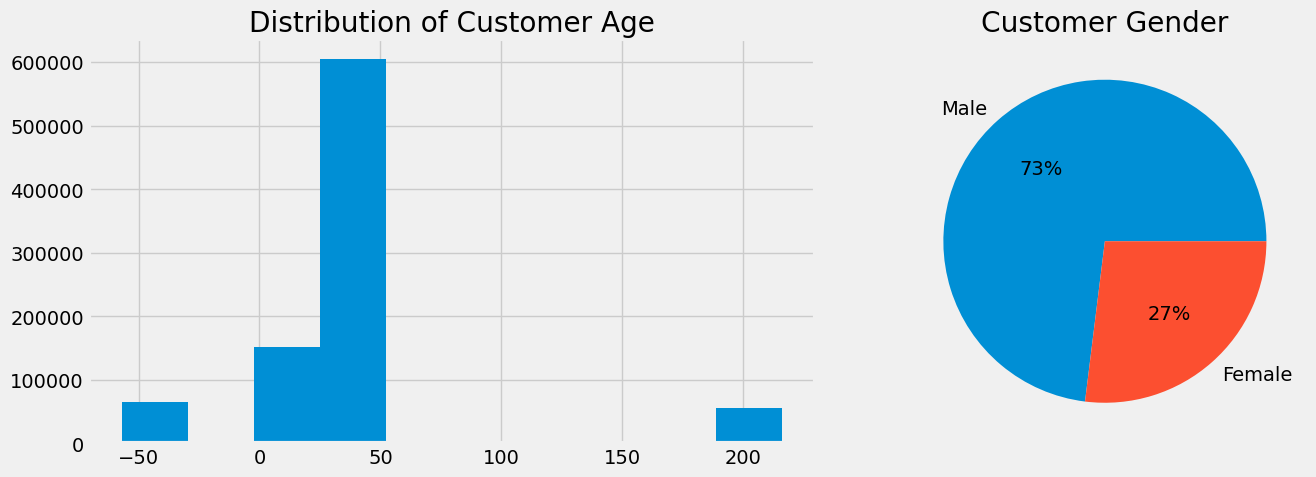

In [16]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0].hist(x=rfm_table['Age'])
ax[0].set_title("Distribution of Customer Age")
ax[1].pie(rfm_table['Gender'].value_counts(),autopct='%1.f%%',labels=['Male','Female'])
ax[1].set_title("Customer Gender")
plt.tight_layout();

In [17]:
print((df['Age'].unique() < 0).sum())
df.drop(df[df['Age']<0].index,inplace=True)

56


<h3 align="left">Transactions by Month and Gender</h3>

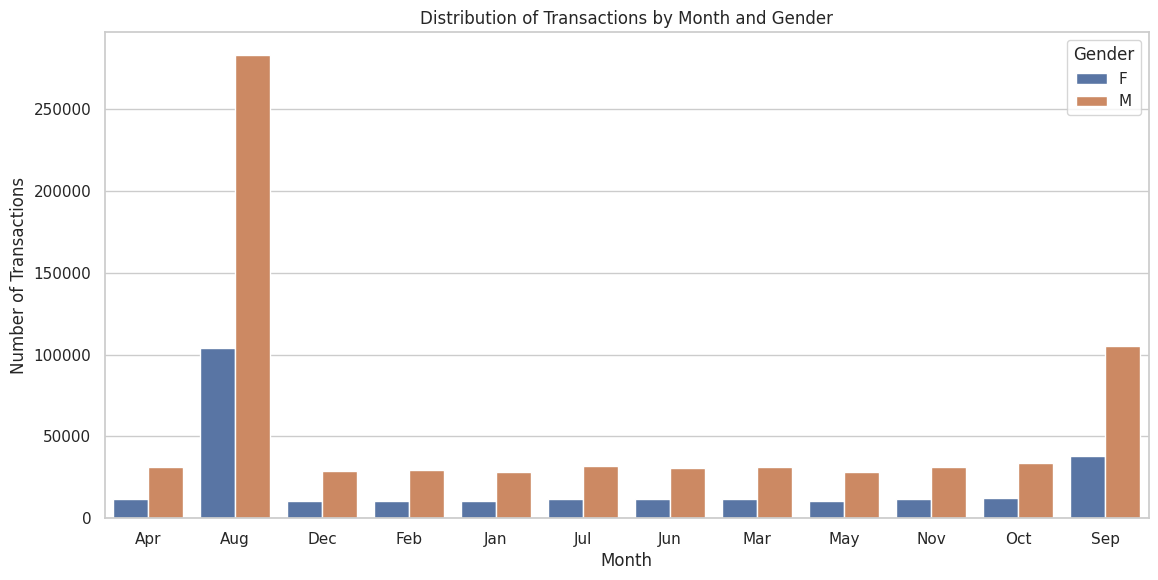

In [18]:
df['Month'] = df['TransactionDate'].dt.strftime('%b')  # Extract month as abbreviated string

# Plotting using Seaborn countplot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Use countplot to show the distribution of transactions for each gender in different months
sns.countplot(data=df, x='Month', hue='Gender', order=sorted(df['Month'].unique()))

plt.title('Distribution of Transactions by Month and Gender')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

<h3 align="left">Correlation between features</h3>

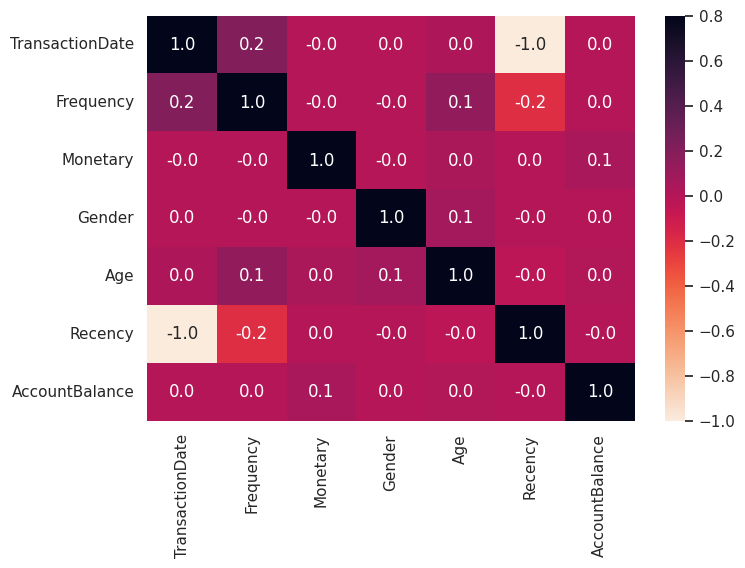

In [19]:
rfm_table.drop(['CustomerID'],axis=1,inplace=True)
rfm_table['Gender'] = LabelEncoder().fit_transform(rfm_table['Gender'])
plt.figure(figsize=(7,5))
correlation=rfm_table.corr()
sns.heatmap(correlation,vmin=None,
    vmax=0.8,
    cmap='rocket_r',
    annot=True,
    fmt='.1f',
    linecolor='white',
    cbar=True);

# 5. Feature Engineering <a class='anchor' id='5'></a>

In [20]:
rfm_table.drop(['Gender'],axis=1,inplace=True)
rfm_table.drop(['Age'],axis=1,inplace=True)
rfm_table.drop(['AccountBalance'],axis=1,inplace=True)
rfm_table.drop(['TransactionDate'],axis=1,inplace=True)

In [21]:
df_scaled=StandardScaler().fit_transform(rfm_table)
df_scaled=pd.DataFrame(df_scaled,columns=rfm_table.columns)
df_scaled.head()

,Frequency,Monetary,Recency
0,1.816407,0.153306,-0.684460
1,-0.410992,-0.010533,-0.147303
2,1.816407,-0.130458,0.314903
3,-0.410992,-0.238881,-0.547048
4,-0.410992,0.533679,-0.197271


In [22]:
rfm_table1 = rfm_table.head(500000)
df_scaled1 = df_scaled.head(500000)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'Inertia')

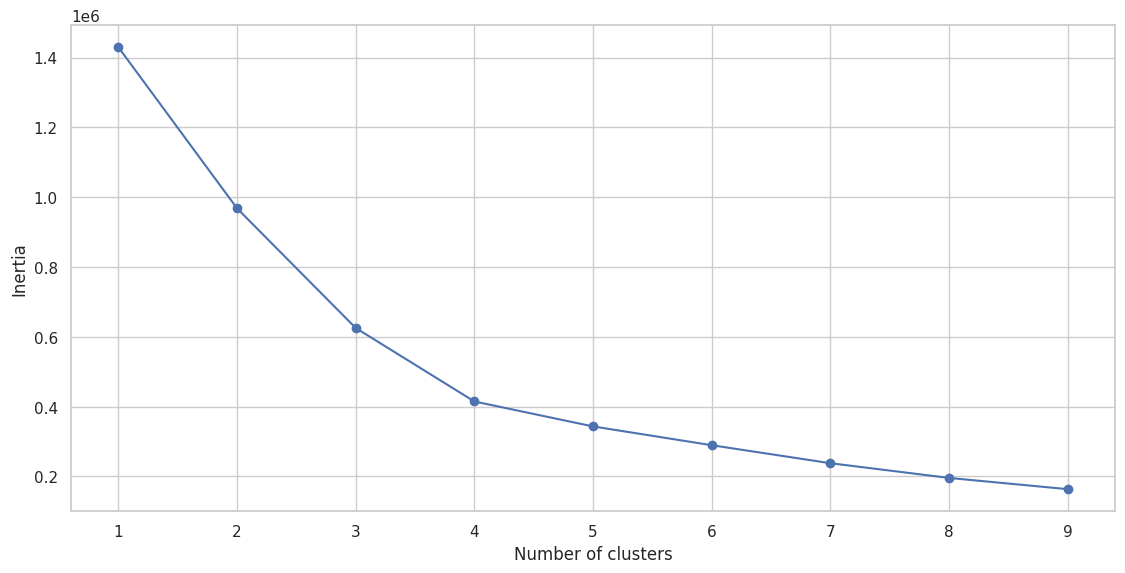

In [23]:

SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(df_scaled1)
    SSE.append(kmeans.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [24]:
kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(df_scaled1)
score = silhouette_score(df_scaled1, kmeans.labels_, metric='euclidean')
print(f"Silhouette Score: {score:.2f}")

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.65


In [25]:
pred = kmeans.predict(df_scaled1)
frame = pd.DataFrame(rfm_table1)
frame['cluster'] = pred
frame 

,Frequency,Monetary,Recency,cluster
0,2,2553.0,75,2
1,1,1499.0,118,0
2,2,727.5,155,2
3,1,30.0,86,0
4,1,5000.0,114,0
...,...,...,...,...
499995,1,675.8,245,1
499996,1,1607.0,114,0
499997,1,128.0,112,0
499998,1,292.0,1,0


In [26]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()

avg_df['Count'] = frame['cluster'].value_counts()

avg_df

,cluster,Frequency,Monetary,Recency,Count
0,0,1.000000,1244.864589,94.662872,310461
1,1,1.009900,1299.668550,260.373715,108077
2,2,2.146389,1411.039732,88.340343,79323
3,3,1.107059,65605.354164,130.378214,2139


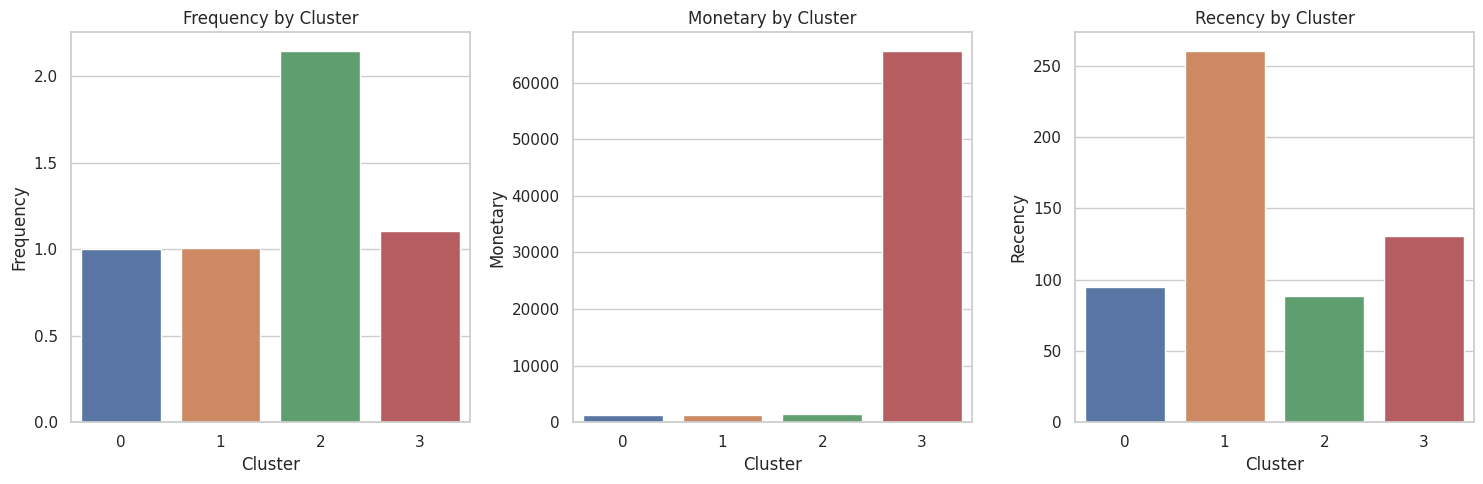

In [28]:
list1 = ['Frequency', 'Monetary', 'Recency']

avg_df = frame.groupby(['cluster'], as_index=False).mean()
fig, axes = plt.subplots(nrows=1, ncols=len(list1), figsize=(15, 5))
# Plot each barplot in a separate subplot
for i, col in enumerate(list1):
    sns.barplot(x='cluster', y=col, data=avg_df, ax=axes[i])
    axes[i].set_title(f'{col} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

<h3 align="left">Analyse</h3>

<pre>
Cluster 0 : Clients loyaux avec potentiel de croissance
- Caractéristiques :
    Fréquence et valeur monétaire modérée des transactions bancaires.
    Transactions récemment effectuées.
- Aperçu :
    Des clients qui montrent un potentiel pour un engagement plus élevé avec la banque.
    Des efforts ciblés peuvent encourager des activités bancaires plus fréquentes,et des transactions monétaires plus importantes.
<pre>

<pre>
Cluster 1: Clients inactifs \ irréguliers
- Caractérstiques :
    Fréquence et valeurs monétaire modérée.
    Période importante depuis leur dernière activité bancaire (ancienne récence).
- Apercu :
    Des clients qui étaient actifs dans le passé mais inactifs récement.
    Les stratégies visant à réactiver ces clients pourraient inclure des promotions personnalisées ou des rappels sur les services de la banque.
<pre>

<pre>
Cluster 2: Nouveaux clients   
- Caractéristiques:
    Activité bancaire récente.
    Fréquence plus élevée des transactions avec valeur monétaire modérée.
- Apercus:
    Clients fidèles qui s'engagent fréquemment auprès de la banque.
    Les stratégies de fidélisation, les conseils financiers personnalisés et les récompenses de fidélité peuvent renforcer leur lien avec la banque.
<pre>

<pre>
Cluster 3: Clients de grande valeur
- Caractérstiques:
    Valeurs monétaires élevées dans les transactions bancaires.
    Fréquence modérément élevée et engagement constant.
- Aperçu:
    Comprend des clients de grande valeur qui effectuent des transactions bancaires importantes et régulières.
    L'accent est mis sur le maintien de leur satisfaction et de leur fidélité grâce à des services bancaires exclusifs ou des solutions financières personnalisées.
<pre>